In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/keras/bert_small_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_small_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/multilabel-classification-dataset/sample_submission.csv
/kaggle/input/multilabel-classification-dataset/train.csv
/kaggle/input/multilabel-classification-dataset/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/multilabel-classification-dataset/sample_submission.csv')

In [3]:
tags = list(df.columns)
tags = tags[1:]
tags

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

In [4]:
train_set = pd.read_csv('/kaggle/input/multilabel-classification-dataset/train.csv')


In [5]:
cols = train_set.columns
import traceback


Idea is to use BERT for TAG Classification problem. 
Finetune the last layer of the bert model..

1. Tokenize the TITLE and ABSTRACT and create a VOCAB (taken care by BERT Tokenizer and Vocab)
2. Fine Tune the last layer of the model. 

In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import keras_nlp
tf.compat.v1.enable_eager_execution()

2024-06-17 13:12:32.377726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 13:12:32.377811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 13:12:32.537700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_set, test_size=0.2)

In [8]:
def get_labels(df):
    labels = []
    for i, row in df.iterrows():
        labels.append([row[k] for k in tags])
    return labels
            

In [9]:
train_labels = get_labels(train)
valid_labels = get_labels(valid)

In [10]:
train = train[['TITLE', 'ABSTRACT']]
valid = valid[['TITLE', 'ABSTRACT']]


In [11]:
#preprocessing layer
preprocess_layer = keras_nlp.models.BertPreprocessor.from_preset('bert_small_en_uncased')

Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((list(train['TITLE']), train_labels)).map(lambda x, y: (preprocess_layer(x), y)).map(lambda x, y: 
                                                                                                                           ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)).batch(64)

Cause: could not parse the source code of <function <lambda> at 0x782e0430bc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)

Match 1:
lambda x, y: (preprocess_layer(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x782e0430bd00>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)

Match 1:
lambda x, y: (preprocess_layer(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_no

In [13]:
valid_dataset = tf.data.Dataset.from_tensor_slices((list(valid['TITLE']), valid_labels)).map(lambda x, y: (preprocess_layer(x), y)).map(lambda x, y: 
                                                                                                                             ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)).batch(64)

Cause: could not parse the source code of <function <lambda> at 0x782e0430bf40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)

Match 1:
lambda x, y: (preprocess_layer(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x782e03d6d240>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: ((x['token_ids'], x['segment_ids'], x['padding_mask']), y)

Match 1:
lambda x, y: (preprocess_layer(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_no

In [32]:
encoder = keras_nlp.models.BertBackbone.from_preset("bert_small_en_uncased", name='bert_layer', trainable=False)

Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...


In [37]:
encoder.summary()

Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 512) │ 15,627,264 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 512) │    262,144 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_embedding   │ (None, None, 512) │      1,024 │ segment_ids[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 512) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
│                     │                   │            │ segment_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 512) │      1,024 │ embeddings_add[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 512) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 512) │  3,152,384 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 512) │  3,152,384 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 512) │  3,152,384 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 512) │  3,152,384 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512)       │          0 │ transformer_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_dense        │ (None, 512)       │    262,656 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,763,648 (109.72 MB)

 Trainable params: 28,763,648 (109.72 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
for i, j in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[  101,  6375, 22318, ...,     0,     0,     0],
       [  101,  2019,  4106, ...,     0,     0,     0],
       [  101, 22380,  1037, ...,     0,     0,     0],
       ...,
       [  101,  7275,  1998, ...,     0,     0,     0],
       [  101,  3935,  4359, ...,     0,     0,     0],
       [  101, 24154,  1998, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(64, 512), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,

In [14]:

def temp_model():
    token_ids = tf.keras.layers.Input(shape=(512, ), dtype=tf.int32, name='token_ids')
    segment_ids = tf.keras.layers.Input(shape=(512, ), dtype=tf.int32, name='segment_ids')
    padding_mask= tf.keras.layers.Input(shape=(512, ), dtype=tf.bool, name='padding_mask')
    
    
    input1 = {
        'segment_ids': segment_ids, 
        'token_ids': token_ids, 
        'padding_mask': padding_mask
    }
    
    encoder = keras_nlp.models.BertBackbone.from_preset("bert_small_en_uncased", name='bert_layer')
    outputs = encoder(input1)
    net = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])
    output = tf.keras.layers.Dense(6, activation=tf.sigmoid, name='sing_dense_layer')(net)
    return tf.keras.Model((token_ids, segment_ids, padding_mask),  output)

In [15]:
model = temp_model()

Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_small_en_uncased/2' to your Kaggle notebook...


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 512, 512)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sing_dense_layer    │ (None, 6)         │      3,078 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,766,726 (109.74 MB)

 Trainable params: 28,766,726 (109.74 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#loss = tf.keras.losses.(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    
    clipnorm=1.0
)

pot = tf.keras.optimizers.SGD()

In [20]:
#model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
from keras.optimizers import Adam
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])

In [30]:
history = model.fit(x=train_dataset, epochs=2, validation_data=valid_dataset, verbose=1)

Epoch 1/2
263/263 ━━━━━━━━━━━━━━━━━━━━ 260s 986ms/step - binary_accuracy: 0.9325 - loss: 0.1689 - val_binary_accuracy: 0.9034 - val_loss: 0.2471
Epoch 2/2
263/263 ━━━━━━━━━━━━━━━━━━━━ 260s 987ms/step - binary_accuracy: 0.9415 - loss: 0.1444 - val_binary_accuracy: 0.9033 - val_loss: 0.2570


In [31]:
import matplotlib.pyplot as plt

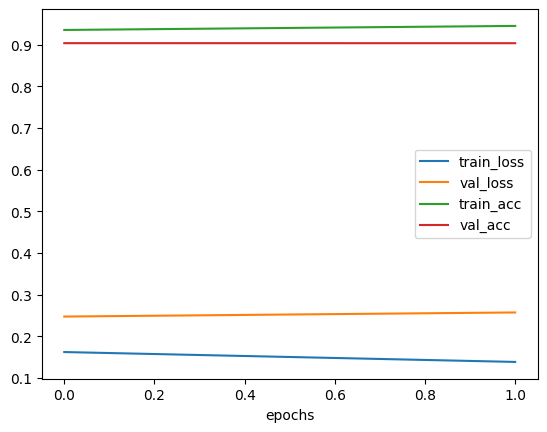

In [36]:
n = len(history.history['loss'])
plt.plot([i for i in range(n)], history.history['loss'], label='train_loss')
plt.plot([i for i in range(n)], history.history['val_loss'], label='val_loss')
plt.plot([i for i in range(n)], history.history['binary_accuracy'], label='train_acc')
plt.plot([i for i in range(n)], history.history['val_binary_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("epochs")
plt.show()



2